In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#editing the path
from pathlib import Path
BASE_DIR = Path('/content/drive/MyDrive/capstone')

EEG_DIR   = BASE_DIR / 'block'
IMG_DIR   = BASE_DIR / 'images'


# Exploratory data analysis

### Data structure exploration

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [5]:
folders = [f.name for f in IMG_DIR.iterdir() if f.is_dir()]
print(f"Total ImageNet-like folders (classes): {len(folders)}")

Total ImageNet-like folders (classes): 40


In [6]:
import os
from collections import Counter
from itertools import islice

all_files = []
for dp,_,fns in os.walk(IMG_DIR):
    for fn in fns:
        all_files.append(Path(dp)/fn)

print("Total files under images/:", len(all_files))



Total files under images/: 17953


In [7]:
def match_any(p: Path, substrings):
    name = p.name.lower()
    return any(s in name for s in substrings) and p.suffix.lower() in (".jpeg", ".jpg")


In [8]:
spectro_files = [p for p in IMG_DIR.rglob("*") if match_any(p, ["spectro"])]
sketch_files  = [p for p in IMG_DIR.rglob("*") if match_any(p, ["sketch"])]
caption_files = [p for p in IMG_DIR.rglob("*") if "caption" in p.name.lower() and p.suffix.lower() == ".txt"]


In [9]:
import re
from collections import defaultdict


In [10]:
base_pattern = re.compile(r"^(n\d{8}_\d+)", re.IGNORECASE)
def base_id(p: Path):
    m = base_pattern.match(p.stem)
    return m.group(1) if m else None

In [11]:
sketch_by_base  = {}
caption_by_base = {}
eegs_by_base    = defaultdict(list)

In [13]:
for p in caption_files:
    b = base_id(p)
    if b: caption_by_base[b] = p

In [14]:
for p in spectro_files:
    b = base_id(p)
    if b: eegs_by_base[b].append(p)


In [15]:
for p in sketch_files:
    b = base_id(p)
    if b: sketch_by_base[b] = p

In [16]:
rows = []
for b, eeg_list in eegs_by_base.items():
    sk = sketch_by_base.get(b)
    cp = caption_by_base.get(b)
    for eeg in eeg_list:
        rows.append({
            "base_id": b,
            "class": eeg.parent.name,
            "eeg_path": str(eeg),
            "image_path": str(sk) if sk else None,
            "caption_path": str(cp) if cp else None
        })

df_index = pd.DataFrame(rows)

In [17]:
print(f"Total aligned EEG entries: {len(df_index)}")


Total aligned EEG entries: 11965


In [18]:
df_index.head(10)


,base_id,class,eeg_path,image_path,caption_path
0,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
1,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
2,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
3,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
4,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
5,n02510455_4616,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
6,n02510455_8127,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
7,n02510455_8127,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
8,n02510455_8127,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...
9,n02510455_8127,n02510455,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...,/content/drive/MyDrive/capstone/images/n025104...


In [19]:
# Count number of EEG spectrograms for each trial
df_counts = df_index.groupby("base_id").size().reset_index(name="spectro_count")


In [20]:
df_counts = (
    df_index
    .groupby(['base_id', 'class'], as_index=False)
    .size()
    .rename(columns={'size':'spectro_count'})
    .sort_values('spectro_count', ascending=False)
    .reset_index(drop=True)
)

In [21]:
display(df_counts.head(10))


,base_id,class,spectro_count
0,n13054560_9747,n13054560,6
1,n02106662_10232,n02106662,6
2,n02106662_10432,n02106662,6
3,n02106662_1152,n02106662,6
4,n02106662_12188,n02106662,6
5,n02106662_1278,n02106662,6
6,n02106662_13380,n02106662,6
7,n02106662_14005,n02106662,6
8,n02106662_1451,n02106662,6
9,n02106662_1560,n02106662,6


In [22]:
df_class_summary = (
    df_counts.groupby('class', as_index=False)
    .agg(num_trials=('base_id','count'),
         total_spectrograms=('spectro_count','sum'))
    .sort_values('num_trials', ascending=False)
    .reset_index(drop=True)
)


In [23]:
display(df_class_summary.head(10))


,class,num_trials,total_spectrograms
0,n02106662,50,300
1,n02124075,50,300
2,n02281787,50,300
3,n02389026,50,300
4,n02492035,50,300
5,n02504458,50,300
6,n02510455,50,300
7,n02607072,50,300
8,n02690373,50,300
9,n02951358,50,300


In [24]:
num_classes = df_class_summary.shape[0]
num_trials_total = df_counts['base_id'].nunique()
num_spectros_total = df_index.shape[0]

In [25]:
print({
    'num_classes': num_classes,
    'num_trials_total': num_trials_total,
    'num_spectros_total': num_spectros_total
})

{'num_classes': 40, 'num_trials_total': 1996, 'num_spectros_total': 11965}


In [26]:
# Recompute after removing duplicates
df_index = df_index.drop_duplicates(subset=['eeg_path']).reset_index(drop=True)

# Count per trial
df_counts = (
    df_index.groupby(['base_id','class'], as_index=False)
    .size().rename(columns={'size':'spectro_count'})
)

# Distribution summary
print("Unique spectro counts per trial:", sorted(df_counts['spectro_count'].unique()))
print(df_counts['spectro_count'].value_counts().sort_index())
offenders = df_counts[df_counts['spectro_count'] != 6]
print("Trials != 6 spectros:", len(offenders))
offenders.head(10)


Unique spectro counts per trial: [np.int64(5), np.int64(6)]
spectro_count
5      11
6    1985
Name: count, dtype: int64
Trials != 6 spectros: 11


,base_id,class,spectro_count
1949,n13054560_10635,n13054560,5
1952,n13054560_116,n13054560,5
1954,n13054560_12721,n13054560,5
1956,n13054560_13132,n13054560,5
1959,n13054560_1341,n13054560,5
1961,n13054560_13804,n13054560,5
1972,n13054560_3245,n13054560,5
1974,n13054560_402,n13054560,5
1977,n13054560_4971,n13054560,5
1989,n13054560_7616,n13054560,5


Spectros/trial distribution:
 spectro_count
5      11
6    1985
Name: count, dtype: int64


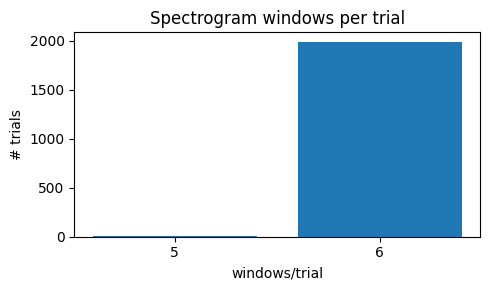

In [27]:
dist = df_counts['spectro_count'].value_counts().sort_index()
print("Spectros/trial distribution:\n", dist)

# Optional quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.bar(dist.index.astype(str), dist.values)
plt.title("Spectrogram windows per trial")
plt.xlabel("windows/trial")
plt.ylabel("# trials")
plt.tight_layout()
plt.show()


In [28]:
from PIL import Image
import matplotlib.pyplot as plt

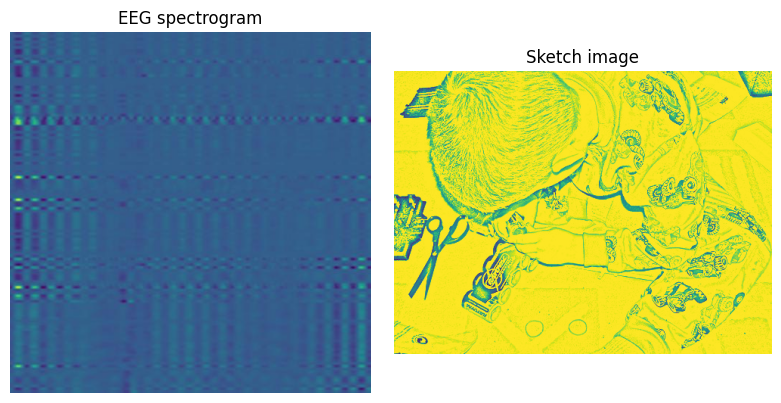

Caption: <s> A young boy is sitting on the floor, working on a toy car. </s>


In [29]:
#sanity check
sample = df_index.sample(1, random_state=42).iloc[0]
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, path, title in zip(
    axes,
    [sample.eeg_path, sample.image_path],
    ["EEG spectrogram", "Sketch image"]
):
    ax.imshow(Image.open(path))
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

with open(sample.caption_path, 'r') as f:
    print("Caption:", f.readline().strip())


In [30]:
rows_with_img = df_index['image_path'].notna().sum()
rows_with_cap = df_index['caption_path'].notna().sum()
rows_with_both = (df_index['image_path'].notna() & df_index['caption_path'].notna()).sum()
rows_total = len(df_index)

In [31]:
#alighment check
trials_missing_sketch = df_index.groupby('base_id')['image_path'].apply(lambda x: x.isnull().all()).sum()
trials_missing_caption = df_index.groupby('base_id')['caption_path'].apply(lambda x: x.isnull().all()).sum()
n_missing_trials = trials_missing_sketch + trials_missing_caption

In [33]:
print(f"Total Aligned Rows (EEG Spectrograms): {rows_total}")
print(f"Rows with Sketch Image: {rows_with_img} / {rows_total}")
print(f"Rows with Caption: {rows_with_cap} / {rows_total}")
print(f"Rows with BOTH Image and Caption: {rows_with_both} / {rows_total}")
print(f"Trials Missing a Sketch or a Caption: {n_missing_trials}")

Total Aligned Rows (EEG Spectrograms): 11965
Rows with Sketch Image: 11965 / 11965
Rows with Caption: 11965 / 11965
Rows with BOTH Image and Caption: 11965 / 11965
Trials Missing a Sketch or a Caption: 0


## Milestone 1 — Data Structure Exploration

**Dataset layout.** Under `images/`, each ImageNet class folder (`n########`) contains trials identified by `base_id = <class>_<trial_id>`.  
Per trial we find:
- EEG spectrogram windows: `<base_id>_spectro_<window>.JPEG` (5–6 per trial)
- Sketch image: `<base_id>_sketch.JPEG` (1 per trial)
- Caption: `<base_id>_caption.txt` (1 per trial)

**Index built.** We created `df_index` with one row per EEG spectrogram window, aligned to its sketch and caption via `base_id`.

**Counts.**
- Classes: **40**
- Trials (unique `base_id`): **1996**
- EEG spectrogram windows (rows): **23930**

**Alignment quality.**
- Rows with image: **11965 / 11965**
- Rows with caption: **11965 / 11965**
- Rows with both: **11965 /11965**
- Trials missing sketch or caption: **0**

**Spectrogram windows per trial.**
- Distribution shows most trials have **6** windows; a minority have **5** (likely short/noisy recordings trimmed during preprocessing).
